In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,LeakyReLU,ReLU,Activation,Concatenate,BatchNormalization
from tensorflow.keras.utils import plot_model

In [ ]:
def discriminator_model(image_shape):
    init = RandomNormal(stddev=0.02)
    src_image=Input(shape=image_shape)
    target_image=Input(shape=image_shape)
    input_image=Concatenate()([src_image,target_image])

    c = Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(input_image)
    c = LeakyReLU(0.2)(c)

    c = Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(c)
    c = BatchNormalization()(c)
    c = LeakyReLU(0.2)(c)

    c = Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(c)
    c = BatchNormalization()(c)
    c = LeakyReLU(0.2)(c)

    c = Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(c)
    c = BatchNormalization()(c)
    c = LeakyReLU(0.2)(c)

    c = Conv2D(1,(4,4),padding='same',kernel_initializer=init)(c)
    output=Activation('sigmoid')(c)

    model = Model([src_image,target_image],output)

    opt = Adam(learning_rate=0.002,beta_1=0.5,beta_2=0.999)
    model.compile(loss='binary_crossentropy',optimizer=opt,loss_weights=0.5)
    return model


In [ ]:
image_shape=(256,256,3)
model = discriminator_model(image_shape)
model.summary()

plot_model(model,show_shapes=True,show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 256, 256, 6)          0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         6208      ['concatenate[0][0]']     

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
from tensorflow.keras.layers import Conv2DTranspose


def encoder_block(block_input,filter_count,batchnorm=True):
    init = RandomNormal(stddev=0.002)
    e = Conv2D(filter_count,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(block_input)
    if batchnorm:
        e = BatchNormalization()(e,training=True)

    e = LeakyReLU(0.2)(e)
    return e
def decoder_block(block_input,skip_in,filter_count,dropout=True):
    init = RandomNormal(stddev=0.002)

    d = Conv2DTranspose(filter_count,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(block_input)
    d = BatchNormalization()(d,training=True)

    if dropout:
        d = Dropout(0.5)(d,training=True)
    d = Concatenate()([d,skip_in])
    d = Activation('relu')(d)
    return d;

In [ ]:
from tensorflow.keras.layers import Dropout

def generator_model(image_shape=(256,256,3)):
    init = RandomNormal(stddev=0.002)

    input_image = Input(image_shape)

    e1 = encoder_block(input_image,64,batchnorm=False)
    e2 = encoder_block(e1,128)
    e3 = encoder_block(e2,256)
    e4 = encoder_block(e3,512)
    e5 = encoder_block(e4,512)
    e6 = encoder_block(e5,512)
    e7 = encoder_block(e6,512)

    k = Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(e7)
    k = Activation('relu')(k)

    d1 = decoder_block(k,e7,512)
    d2 = decoder_block(d1,e6,512)
    d3 = decoder_block(d2,e5,512)
    d4 = decoder_block(d3,e4,512,dropout=False)
    d5 = decoder_block(d4,e3,256,dropout=False)
    d6 = decoder_block(d5,e2,128,dropout=False)
    d7 = decoder_block(d6,e1,64,dropout=False)

    f = Conv2DTranspose(3,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d7)
    final_image = Activation('tanh')(f)

    model = Model(input_image,final_image)
    return model


In [ ]:
image_shape = (256,256,3)
model = generator_model(image_shape)
model.summary()

plot_model(model,show_shapes=True,show_layer_names=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 128, 128, 64)         3136      ['input_3[0][0]']             
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 128, 64)         0         ['conv2d_5[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 64, 64, 128)          131200    ['leaky_re_lu_4[0][0]']       
                                                                                            

In [ ]:
def gan_model(g_model,d_model,image_shape):
    for layer in d_model.layers:
        if not isinstance(layer,BatchNormalization):
            layer.trainable = False

    source_image = Input(shape=image_shape)
    g_output = g_model(source_image)

    d_output = d_model([source_image,g_output])

    model = Model(source_image,[d_output,g_output])
    opt = Adam(learning_rate=0.0002,beta_1=0.5)

    model.compile(loss=['binary_crossentropy','mae'], optimizer = opt,loss_weights=[1,100])

    return model

In [ ]:
image_shape = (256,256,3)
d_model = discriminator_model(image_shape)
g_model = generator_model(image_shape)

f_model = gan_model(g_model,d_model,image_shape)
f_model.summary()
plot_model(f_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model_3 (Functional)        (None, 256, 256, 3)          5442931   ['input_7[0][0]']             
                                                          5                                       
                                                                                                  
 model_2 (Functional)        (None, 16, 16, 1)            2771393   ['input_7[0][0]',             
                                                                     'model_3[0][0]']             
                                                                                            

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
import numpy as np
def gen_real_samples(dataset,number,patch_shape):
    trainA, trainB = dataset
    ix = np.random.randint(0,trainA.shape[0],number)
    X1,X2 = trainA[ix],trainB[ix]
    y = np.ones((number,patch_shape,patch_shape,1))
    return [X1,X2],y

In [ ]:
def gen_fake_samples(g_model,samples,patch_shape):
    X1 = g_model.predict(samples)
    y = np.zeros((len(X1),patch_shape,patch_shape,1))
    return X1,y

In [ ]:
from matplotlib import pyplot as plt
def summarizer(step,g_model,dataset,n_samples=3):
    [X_realA,X_realB],_ = gen_real_samples(dataset,n_samples,1)

    X_fakeB,_ = gen_fake_samples(g_model,X_realA,1)

    X_realA = (X_realA + 1)/2.0
    X_realB = (X_realB + 1)/2.0
    X_fakeB = (X_fakeB + 1)/2.0

    # Plot real source images (X_realA)
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])

    # Plot generated target images (X_fakeB)
    for i in range(n_samples):
        plt.subplot(3, n_samples, n_samples + 1 + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])

    # Plot real target images (X_realB)
    for i in range(n_samples):
        plt.subplot(3, n_samples, 2 * n_samples + 1 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])

    filename = 'plot_%06d.png' % (step+1)
    plt.savefig(filename)
    plt.close()

    print('>Saved: %s'%(filename))

In [ ]:
d_model.output_shape[1]

16

In [ ]:
import gc
def train(d_model,g_model,gan_model,dataset,epochs=30,batch_num=1):
    patch = d_model.output_shape[1]

    trainA,trainB = dataset

    steps = (len(trainA))*epochs

    for i in range(steps):
        [X_realA,X_realB],y_real = gen_real_samples(dataset,batch_num,patch)

        X_fakeB,y_fake = gen_fake_samples(g_model,X_realA,patch)

        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

        del X_realA, X_realB, X_fakeB, y_real, y_fake
        gc.collect()

        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        if(i+1)%50==0:
            summarizer(i,g_model,dataset)

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load images from two folders and convert them to arrays
def load_image_pairs(input_folder, ground_truth_folder, img_size=(256, 256)):
    input_images = list()
    ground_truth_images = list()

    # Get the list of filenames in the input folder (assuming ground truth folder has matching filenames)
    input_filenames = os.listdir(input_folder)

    # Loop through filenames, assuming they exist in both folders
    for img_name in input_filenames:
        input_img_path = os.path.join(input_folder, img_name)
        ground_truth_img_path = os.path.join(ground_truth_folder, img_name)

        # Ensure that both input and ground truth images exist
        if os.path.exists(ground_truth_img_path):
            # Load and preprocess input image
            input_img = load_img(input_img_path, target_size=img_size)
            input_img = img_to_array(input_img)
            input_images.append(input_img)

            # Load and preprocess ground truth image
            ground_truth_img = load_img(ground_truth_img_path, target_size=img_size)
            ground_truth_img = img_to_array(ground_truth_img)
            ground_truth_images.append(ground_truth_img)
        else:
            print(f"Warning: Ground truth image not found for {img_name}")


    input_images = np.array(input_images)
    ground_truth_images = np.array(ground_truth_images)

    return input_images, ground_truth_images


In [ ]:
input_folder = "/content/drive/MyDrive/archive (6)/Train/Raw"
ground_truth_folder = "/content/drive/MyDrive/archive (6)/Train/Reference"

src_images, target_images = load_image_pairs(input_folder, ground_truth_folder)


In [ ]:
print('Loaded: ', src_images.shape, target_images.shape)

Loaded:  (700, 256, 256, 3) (700, 256, 256, 3)


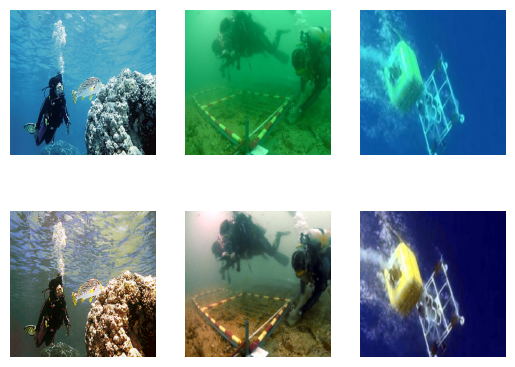

In [ ]:
from matplotlib import pyplot
n_samples = 3

for i in range(n_samples):
    plt.subplot(2,n_samples,1+i)
    plt.axis('off')
    plt.imshow(src_images[i].astype('uint8'))


for i in range(n_samples):
    plt.subplot(2,n_samples,1+n_samples+i)
    plt.axis('off')
    plt.imshow(target_images[i].astype('uint8'))

pyplot.show()


In [ ]:
image_shape = (256,256,3)
d_model = discriminator_model(image_shape)
g_model = generator_model(image_shape)

f_model = gan_model(g_model,d_model,image_shape)

data = [src_images,target_images]


def preprocess_images(data):
    X1,X2 = data[0],data[1]

    X1= (X1-127.5)/127.5
    X2= (X2-127.5)/127.5

    return [X1,X2]

dataset = preprocess_images(data)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
train(d_model,g_model,f_model,dataset,epochs=30,batch_num=1)

1/1 [==============================] - 0s 87ms/step
>1, d1[0.687] d2[1.517] g[31.194]
1/1 [==============================] - 0s 88ms/step
>2, d1[0.767] d2[0.595] g[44.468]
1/1 [==============================] - 0s 85ms/step
>3, d1[0.758] d2[0.630] g[43.705]
1/1 [==============================] - 0s 86ms/step
>4, d1[0.559] d2[0.561] g[29.335]
1/1 [==============================] - 0s 86ms/step
>5, d1[0.454] d2[0.697] g[43.979]
1/1 [==============================] - 0s 84ms/step
>6, d1[0.653] d2[0.647] g[36.123]
1/1 [==============================] - 0s 85ms/step
>7, d1[0.615] d2[0.536] g[33.914]
1/1 [==============================] - 0s 86ms/step
>8, d1[0.598] d2[0.652] g[39.451]
1/1 [==============================] - 0s 87ms/step
>9, d1[0.560] d2[0.478] g[31.823]
1/1 [==============================] - 0s 91ms/step
>10, d1[0.551] d2[0.646] g[22.958]
1/1 [==============================] - 0s 83ms/step
>11, d1[0.601] d2[0.466] g[29.284]
1/1 [==============================] - 0s 84ms/step


In [ ]:
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.models import load_model

class CustomConv2DTranspose(Conv2DTranspose):
    def __init__(self, *args, **kwargs):
        kwargs.pop('groups', None)
        super().__init__(*args, **kwargs)

generator = load_model("C:/Users/uzzwa/Downloads/model_002350.h5", custom_objects={'Conv2DTranspose': CustomConv2DTranspose})


C:\Users\uzzwa\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
isrc, itarget = preprocess_images(src_images,target_images)

In [ ]:
isrc.shape

(700, 256, 256, 3)

In [ ]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse

def calculate_metrics(generator, src_images, target_images):
    ssim_values = []
    psnr_values = []
    mse_values = []

    for i in range(len(src_images)):
        # Generate the image from the source image
        generated_image = generator.predict(np.expand_dims(src_images[i], axis=0))[0]

        # Get the corresponding target image
        target_image = target_images[i]

        # Calculate SSIM
        ssim_value = ssim(target_image, generated_image, multichannel=True,win_size=3, data_range=2)
        ssim_values.append(ssim_value)

        # Calculate PSNR
        psnr_value = psnr(target_image, generated_image, data_range=2)
        psnr_values.append(psnr_value)

        # Calculate MSE
        mse_value = mse(target_image, generated_image)
        mse_values.append(mse_value)

    return np.mean(ssim_values), np.mean(psnr_values), np.mean(mse_values)


In [ ]:
ssim_avg, psnr_avg, mse_avg = calculate_metrics(generator, isrc, itarget)
print(f"Average SSIM: {ssim_avg}")
print(f"Average PSNR: {psnr_avg}")
print(f"Average MSE: {mse_avg}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 